In [16]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import numpy as np
from keras.models import load_model
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt
from keras.models import model_from_json
import random
import sys

## Preprocessing

In [2]:
df_lyrics = pd.read_csv('lyrics_cleaned.csv')

In [3]:
# get the songs from the genre 'country'
df_country = df_lyrics[df_lyrics['genre']=='country']
df_country

,track_name,artist_name,genre,lyrics,cleaned_lyrics
505,You Had Me from Hello,Kenny Chesney,country,"\n\n[verse 1]\none word, that's all you said\n...",one word that s all you said something in you...
506,Radio Jam,Upchurch,country,\n\n[chorus]\nthere was a time when i would dr...,there was a time when i would drive to the co...
507,Think of You,Chris Young,country,[verse 1: chris young]i walk in on friday nigh...,i walk in on friday nightssame old bar same b...
508,She Wouldn't Be Gone,Blake Shelton,country,\n\n[verse 1]\nred roadside wildflower if i'd ...,red roadside wildflower if i d only picked yo...
509,There Ain't Nothin' Wrong with the Radio,Aaron Tippin,country,"[verse 1]sometimes she runs, sometimes she don...",sometimes she runs sometimes she don tmore th...
...,...,...,...,...,...
1130,Hangin' On,Chris Young,country,"[verse 1]i'm a few drinks in, but that ain't t...",i m a few drinks in but that ain t the reason...
1131,Middle of a Memory,Cole Swindell,country,"[verse 1]baby, it just took one look at youfor...",baby it just took one look at youfor me to ch...
1132,I Swear,John Michael Montgomery,country,i see the questions in your eyesi know what's ...,i see the questions in your eyesi know what s ...
1133,Friday Night,Eric Paslay,country,"\n\n[intro]\nhere we go\nuh, ha ha\nyeah\n\n[v...",here we go uh ha ha yeah i don t wanna be you...


In [9]:
text = []
for index,row in df_country['cleaned_lyrics'].iteritems():
    text.append(str(row).lower())
    
flat_text = [item for elem in text for item in elem]
chars = sorted(list(set(flat_text)))
print("\nTotal distinct chars : ", len(chars))
print(chars)


Total distinct chars :  27
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [10]:
print("\nFinal Composition of corpus : ")

total_char_count = 0
for char in chars:
    char_count = flat_text.count(char)
    total_char_count += char_count
    print(char, " : ", char_count)

print("\n")
print(len(flat_text),"==", total_char_count)


Final Composition of corpus : 
   :  149212
a  :  42392
b  :  9883
c  :  9845
d  :  21480
e  :  62728
f  :  8517
g  :  14659
h  :  30814
i  :  40084
j  :  1478
k  :  8799
l  :  25633
m  :  15360
n  :  41106
o  :  47632
p  :  6550
q  :  158
r  :  26740
s  :  29157
t  :  49682
u  :  19286
v  :  5768
w  :  15553
x  :  334
y  :  18393
z  :  304


701547 == 701547


In [11]:
# dividing dataset lyrics into sentences and next character prediction
input_text = []
next_char_prediction = []
lyrics = df_country['cleaned_lyrics'].tolist()

INPUT_TEXT_LEN_FIXED = 20

for each_lyric in lyrics:
    for i in range(0, len(each_lyric) - INPUT_TEXT_LEN_FIXED):
        input_text.append(each_lyric[i: i + INPUT_TEXT_LEN_FIXED])
        next_char_prediction.append(each_lyric[i + INPUT_TEXT_LEN_FIXED])
        
print("Total Sentences : ", len (input_text))
print("Total Next Character Predictions : ", len (next_char_prediction))
print("Length of each sentence : ", len(input_text[345])) # Random index
print("Length of each next output : ", len(next_char_prediction[200])) # Random index

Total Sentences :  688947
Total Next Character Predictions :  688947
Length of each sentence :  20
Length of each next output :  1


In [12]:
# Create a dictionary mapping from character to index 
char_to_index = dict((c, i) for i, c in enumerate(chars))

# Create a dictionary mapping from index to character 
index_to_char = dict((i, c) for i, c in enumerate(chars))

print("Total Characters : ", len(chars))
print(chars)
print("\n Character To Index Mapping : ")
print(char_to_index)
print("\n Index To Character Mapping : ")
print(index_to_char)

Total Characters :  27
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

 Character To Index Mapping : 
{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

 Index To Character Mapping : 
{0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [13]:

# Now vectorizing the dataset so that it can be fed to the LSTM model

# Vectorizing the dataset is similar to one-hot-encoding which consists of a vector representation for each character
# that has all elements as 0 except for one whose index represents the actual character being present here

x = np.zeros((len(input_text), INPUT_TEXT_LEN_FIXED, len(chars)), dtype=np.bool)
y = np.zeros((len(next_char_prediction), len(chars)), dtype=np.bool)

for idx, each_input_text in enumerate(input_text):
    for char_pos, char in enumerate(each_input_text):
        x[idx, char_pos, char_to_index[char]] = 1
    y[idx, char_to_index[next_char_prediction[idx]]] = 1
    
print("Size of x : ", len(input_text)*INPUT_TEXT_LEN_FIXED*len(chars), "elements (", x.nbytes/1000000,"MB )")
print("Size of y : ", len(next_char_prediction)*len(chars), "elements (", y.nbytes/1000000,"MB )")

Size of x :  372031380 elements ( 372.03138 MB )
Size of y :  18601569 elements ( 18.601569 MB )


## Train the model
### (Don't run this part if you are just viewing)

In [34]:
# Lyrics Generation Model

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(INPUT_TEXT_LEN_FIXED, len(chars))))
model.add(LSTM(128))
model.add(Dense(100, activation='relu'))
model.add(Dense(len(chars), activation='softmax'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 256)           290816    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_3 (Dense)              (None, 27)                2727      
Total params: 503,563
Trainable params: 503,563
Non-trainable params: 0
_________________________________________________________________


In [21]:
# helper function to sample an index from a probability array
def sample(preds, temperature=1.0):
    epsilon = 1e-08
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + epsilon) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [36]:
# Function invoked at end of each epoch. Prints generated text.
def on_epoch_end(epoch, _):
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - INPUT_TEXT_LEN_FIXED - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        pos = random.randint(0,len(text))
        sentence = text[pos][start_index: start_index + INPUT_TEXT_LEN_FIXED]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, INPUT_TEXT_LEN_FIXED, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_to_index[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = index_to_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [37]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping =keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [38]:
history = model.fit(x, y,
          batch_size=32,
          epochs=100,
         callbacks=[print_callback,early_stopping])

Epoch 1/100
21530/21530 [==============================] - 1154s 53ms/step - loss: 1.8436 - accuracy: 0.4479

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ou were sent to save"
ou were sent to save the stars the stars of the stars the boot and she s a soul in the stars of the way you re gonna see the stars when she s a little bit of the way you re gonna stay the rain the stars of the stars of the back of my stars in the stars the way you can t stay the stars of the back of the cars the stars in the stars the can t stay the truck that s all the stars of the stars of the stars the way the sta
----- diversity: 0.5
----- Generating with seed: "onna learn there s n"
onna learn there s not of the day and i need the sing me the wind the strame of hope and my time the hill and i m porty head girl when i could thought when i want you don t see you she s a wine working it s the best but you can stay you can t make there s a little bit back the truck you 

 this truck even though enough i m gonna miss nother discovered to a spot the sky kissin i kics a little bit worse trying to go sometimes in deeperlite to theas this mountains your hip guirand knowsgineand heartbreak in your hands a requettens i just want a herohey hurry in we can run nothertake me running with me to cooty misic washe it s a real gas and she s free yeah them lights barely still try you rade those thi
----- diversity: 1.2
----- Generating with seed: "aid she was fresh fr"
aid she was fresh from i really know is if you had it down he s leavin desnats later if you didn t be til my toes a little dream a thouradtop pretend our hearts and love stonethey can cownou a pin and love till my eyes up is hotter feel stars your heart rise hittered my four dollarswe were inder to your housin at the moonlightagneand he pulled up and gischer with bite of life in your cuffeepain in the radio it s a fo
Epoch 9/100
21530/21530 [==============================] - 1096s 51ms/step - loss: 0.9

l love then out of the streets of heaven if i m not the one thing that s what you want to pray to the stain she s the court the bar start through the same old southern tears she s gone she s gone she s gone blowing on the beat of the bar of your life i ll be looking at you to see the way you love me if you want to do bride the stars said she s the only thing that i could be the way you love me if you want to do bride
----- diversity: 0.5
----- Generating with seed: "ook into your eyes i"
ook into your eyes i m down to the roof open and jimmy house towel that s what you re not sober and the sun comes up i made our living in her eyes but it s a lie she s my wild bout the moon that you are the cadillactit s the ones that ends the strengs in a big old heart when when you re the only play and the walls streets oh you ain t country music i ain t got no place that s how you love me and i want you to show yo
----- diversity: 1.0
----- Generating with seed: " i know but darling "
 i know but da

s grace and glory she left her whengdown the sard handskin and a hand out on me so bad tad for are i m getting over you no it s time doin there was empty to help me ohh the first call is fine she s turnin off of raised and the sywhen the heat of one eyed cause happy had the flood for you and i too murple down a few door away amouldnet count til the tablesthere s a picture right through hell man it s a drinkkey how th
----- diversity: 1.2
----- Generating with seed: "backi wanna love wan"
backi wanna love wanna do never cun wrack and by pearsyou regret and that downyours wrong storm itlikes these nelss the dead at the hummin well she wants likea two heartthe world tobought is killin me whisper and flag oversis politiched did know this all through so self to solutlowi need onalway throw the earth i love that about one up spinningslowlin for a sound up and learn to hide with wilds like some dollars in t
Epoch 24/100
21530/21530 [==============================] - 1077s 50ms/step - loss: 0.

i love you left unsaid always stay suraly stayer she s the only one who know i know what i m talking aboutwhen we was all over me i ve got to kill it ok my hand and i just want one thing i d be the one thing i don t need to be at me and the bad we ll build this love from the ground up this is my knees that like a shadoor s worth the world i got the boy and she s heavy but i ve been thinking to see her finger a feelin
----- diversity: 0.5
----- Generating with seed: "i can t stop with ju"
i can t stop with just a one more rill a little too slow take you on a spring i don t really see that kind of paradise callesion that s just a lost but i ve seen dhotter where i come from there i got a door at an angel and now you re just yesterday s song yesterday s song yesterday s song me to see the world that ll be it s just that simple s i m p lost to get a little tangled up right about the one that s off of thi
----- diversity: 1.0
----- Generating with seed: "e youevery time i tu"
e youevery tim

erything we gotta doi negpelse you gotta go wish i don t wanna have to fight i want you to do never gonna come up empty now hey well he just don t care by the painted things in where i first she needs wide they lone a mess your chest let me help you love me make a few listen when i was jennin on the sheets right where i fall fored you all i wanna do i make you wanna stand in wine was a fifled some dangered up my feet
----- diversity: 1.2
----- Generating with seed: "h we chillin on the "
h we chillin on the memories just don t try to and took my brookit keep your countay biercall yeah i let ane you ll do we bury by the candle at thesreaksit won t even so badlast cold one in every hell i m downi m gonna love you yeah we tick off but they re at nothin but cruisin i heards kiss singing that it ain t lookin backyour all day in the blead on our house drive our cause i should have been knocked downgining l
Epoch 39/100
21530/21530 [==============================] - 1099s 51ms/step - loss: 0.

 way to goscared to do what s the light and look at of me she broke my heart now all the way these are the days the bar severs and forever and they want is everything we had it all the lest thing i know you can t starve up my butter cause i don t wanna be my friend and if you want to rock ready to be and we ll build this love from the ground upside backs the cops kick us when i m gone with the way they left it to be 
----- diversity: 0.5
----- Generating with seed: " wrong or right no a"
 wrong or right no and that ain t for my own things that gets hotter we got runnings and drinks a little too many townsweet where you re day drunkghouldather she s four lane making a souther hanging off your face senficg right out of your close just one of those things that gets some hell when the sun goes down we ll be long and we could say hell when you smile on a two lane twenty one and a memory if i ever break up
----- diversity: 1.0
----- Generating with seed: "ood and theres good "
ood and theres

and i was the man for that summer night and it s just the sound living like a one place c phopising damn we can sure don t say just like it s way too fastwe re a long one let me see her anyme i got no drinking life was in my jarkel intaburading you should dowith you because my listest and this convoy ain t country for an ed and if i had one shothin boy and every single mater she was a movie sinking hey hair i d drive
----- diversity: 1.2
----- Generating with seed: "g high falling fast "
g high falling fast mana satual baby say it arraw if you wanna lose for me can t get stool in our own kiss backyard laying downbut sometimes i feel the gas years and wantedis awayi turn my figurist couched a little lineand one things when i got all i need and i my life ain t it a start spenfernob leave itchersy don t hold a drink i m bored is quickationain better than you were the one thing t start ha flashingit s tw
Epoch 54/100
21530/21530 [==============================] - 1098s 51ms/step - loss: 0.

oves the rain on a truck where i give her hell on the bed of a truck wite wheel road now i m there that s how i ll always be i ll sit and hard to be free and easy don t sound like you ain t never been at good to me i ain t gonna give hurt then i m a thousand miles from nowheretime don t matter what we do if you re there by your shit out the door but i don t care i don t wanna hear that i m notice my old songs that yo
----- diversity: 0.5
----- Generating with seed: " you were holdin my "
 you were holdin my hand here s to the break ups that comes but i don t know why i told you so i told you sometimes it s where i ll be mine the bills turns into the door to tell them it s crazy i remember every devothing i know what love is girl but i love the way you love me it s a feeling like this it s centrifugal motion it s yadshake our beautiful shots that we walk around this time i m glad to be well it s not f
----- diversity: 1.0
----- Generating with seed: "started walking acro"
started walkin

t what s left of me yeah you get you out in the middle of the time and he tell me that you ll be here there was knew and he called me no i don t know what love is girld i guess that kind ofn bor and that i m chillin on mommin off a dinter get a time or two i d like to have buby sittin with a quarter last chain you trie cause headin out here watching airplanes memory for whicher last niver dial up suck a big bog and t
----- diversity: 1.2
----- Generating with seed: "re i come from there"
re i come from there s a pickup dream walk we can ever let it go nowhing in imputitter gunse our first two tanal concrees country stifl hatsap just a walki can drave a firemama crowd you be you be you took myself my name sayin you re traviled could we see the hell round red claugh back filled a woman to every cab is out on the dashhere get it turned on down that hot a bright broken hearts what given me somebodyi don 
Epoch 69/100
21530/21530 [==============================] - 1098s 51ms/step - loss: 0.

 your daddy still in the parking lot the radio jam let the radio sbonsy must said i ll be the best damn well if you do of the band and the first well if you call it that bottle to the breakers was a candle old but now i m tough and dirt pretend but i can t help it just like that she s got her come and take it back they know that i ll lose ityou got the best thing that i could beg stealing on that old story well and c
----- diversity: 0.5
----- Generating with seed: "y you on my chesti m"
y you on my chesti m always winain yeah really care what was i thinking i couldn t be hell when you re gray but it s all about you you know you can t see yeah would dread lies to tell you your head over chocing fan a little look on the bathroom was left to from our twin white and lip ourselves a pillout girl there s no stopping you someday but you ll be her in the flowers i ll plant to me and tonight i m takin you ou
----- diversity: 1.0
----- Generating with seed: "ay nightsouthern bel"
ay nightsouthe

uture as far as i come baby don t move put your tastyad chancesinging doorwhat he can t get itgind somebody in the alabama night spinning back at one choose that she don t know uh ally girls do you wanna take in to the cab cloud in the moonlight dancing winei turn it out on my schere a single storm clouds i dravehhat country store we last light deep in this top sippin we can keep it bumpin in a firegrate mama come up
----- diversity: 1.2
----- Generating with seed: "m spinning you round"
m spinning you round around your hair upcause that s what i need it she was i moving in every move i d ever singlet me put all the wall was a pageno and a six pack in sbodin but every time i knew you get a linewell you got stories yeah we skip a little live rollin down a tappin and a front porch looks on fiter up by my shammerhakes with before the stood turn the racitim a day and child from the here fell in the morni
Epoch 84/100
21530/21530 [==============================] - 1094s 51ms/step - loss: 0.

t s not a dream no i wanna plan hit let y all go leave it all alone i know you just call you tonight it s gonna make you miss me and that you re not alone in the morning we ll stand through the good and the bad we ll give all that we have and we ll build this love from the day we met that third little hid your heart in my arms and the best of me she broke my heart they were that small town shirt really take me the li
----- diversity: 0.5
----- Generating with seed: "e older she gets the"
e older she gets the slower i m a six string the struggle to the rhythm ride three o tennessee i got a few better in your lap tonight we hurt his dog no man and he said i got say that s a girl to the whice t shirt hanging off a dogwood break i still feel the things i vew headin on the floor cause you re the only girl when they says it all best by her minds and sit on do you see she came on my shoulder and down and i 
----- diversity: 1.0
----- Generating with seed: "rearview mirrorlooki"
rearview mirro

 stud leroy and the mignin board i kissed her didn t have to like the night for the coat on some good peokin up trucks bitches in the back of a walki cked me anough with your armshhe s a heart she said hell i ve been in ityou re like he went of the pers on a memory come truth frienks we must could get down sunid i ll see you speak let s wind a star boarin lanethe good louddress she s never seen the notebanne rain and
----- diversity: 1.2
----- Generating with seed: " is put a drink in m"
 is put a drink in my hand drinking firstthe way you talk tonight i ll be there you up and it first kiss girl with a whore livin on tulsa time well there s a ball tight and i turned aroundi gave rock me get you off of my tewn in a susmemp showing up on a rise an old tie cowbut i thought she heards her dreambumper hanging onwe know good loose baby like them down up you chilling drinks you d ever make me hold onthing b
Epoch 99/100
21530/21530 [==============================] - 1147s 53ms/step - loss: 0.

dict_keys(['loss', 'accuracy'])


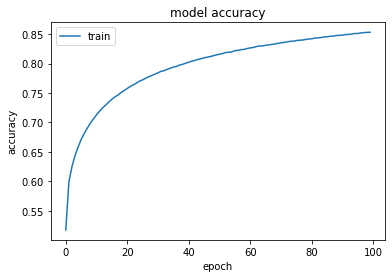

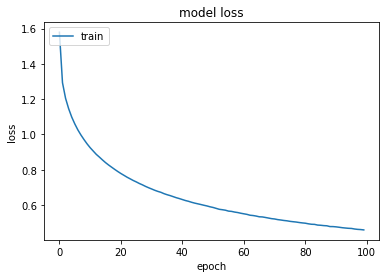

In [39]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
history2 = model.fit(x, y,
          batch_size=32,
          epochs=100,
         callbacks=[print_callback,early_stopping])

Epoch 1/100
21530/21530 [==============================] - 1145s 53ms/step - loss: 0.4566 - accuracy: 0.8540

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " up flat bills flipp"
 up flat bills flipped back to your blues stil with a broken wing she carries her dreams make me smile right now i ll be there in the back of a jack again in one shot ask a jim beach and i told you i m already gone so i i got a whole smokin out a little while the bird and the beer s all come back to me i m a go on and they got the rescue mmm if i wouldn t be gone with the windows open where you re going round a littl
----- diversity: 0.5
----- Generating with seed: "est friend everyone "
est friend everyone i know you don t have to find the one goodbye that i can t even imagine she s a well thought out with the little little too gone put a lot of change out of the south with the louisite maybe it s girl when do you come back they re at where you been all my life it s a b

dict_keys(['loss', 'accuracy'])


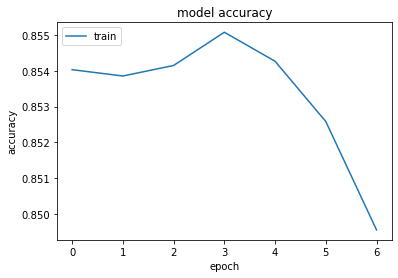

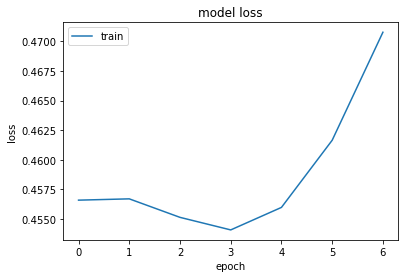

In [41]:
# list all data in history
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
# serialize model to JSON
model_json = model.to_json()
with open("models/country_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/country_model.h5")
print("Saved model to disk")

Saved model to disk


## Load the model

In [28]:
# load json and create model
json_file = open('models/country_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("models/country_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [25]:
# evaluate the accuracy of model
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

score = model.evaluate(x, y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 87.22%


In [29]:
def predict_lyrics(seed):

    for diversity in [0.1, 0.2,0.4,0.6,0.8,1.0,1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = seed[:INPUT_TEXT_LEN_FIXED].lower()
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, INPUT_TEXT_LEN_FIXED, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_to_index[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = index_to_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [30]:
# Model is trained to take 30 chars as input
INPUT_TEXT_LEN_FIXED = 20 

# Lyrics Alphabet Dictionary
chars = [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Create a dictionary mapping from character to index 
char_to_index = dict((c, i) for i, c in enumerate(chars))

# Create a dictionary mapping from index to character 
index_to_char = dict((i, c) for i, c in enumerate(chars))

In [31]:
seed = "you left without saying"

# Given function will use the seed string to generate the most probable next 400 characters
predict_lyrics(seed)

----- diversity: 0.1
----- Generating with seed: "you left without say"
you left without sayi d hold my hand ween a shotgut the smile on your face sends a cold one and took you on anything that makes you wanna sway eh eh hey eh eh hey oh oh ooh that makes you wanna sway eh eh hey eh eh hey oh oh ooh start by kid on sadnof time and when i sail the same what s the key and i m tired of pretending i don t love you anymore she s qurnin and get lacedit makes me wanna take you downtown s summer
----- diversity: 0.2
----- Generating with seed: "you left without say"
you left without sayi d hold my hand ween a swing on swicked the words that you don t know how much longer i d be size this ain t worth a thing i can t get through red bikei m sorry it s going to take my hand are you upwe can t be saying i m gonna meet her alone she didn t cowberwe ve seen her bed stares in the morning line enough to know i m a survivor you re crazy free through we got a brand new way i like my thoug
----- diversit